Completed Testing

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import sys


In [25]:
# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, root_dir, sub_folder, transform, data_type='original'):
        self.root_dir = root_dir
        self.sub_folder = sub_folder
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []
        self.crop = True  # Crop parameters as a tuple: (top, bottom, left, right)

        if self.data_type == 'original':
            self.load_original_data()
        elif self.data_type == 'augmentation':
            self.load_augmented_data()

    # Iterate through the video folders
    def load_original_data(self):
        label_file = os.path.join(self.root_dir, 'shortaxis_binary v2.xlsx')  # DSI_research/shortaxis_binary.xlsx
        numVideos = 0
        for video_folder in os.listdir(os.path.join(self.root_dir, self.sub_folder)):
            if os.path.isdir(os.path.join(self.root_dir, self.sub_folder, video_folder)):
                video_path = os.path.join(self.root_dir, self.sub_folder, video_folder)  # DSI_research/video/AM12
                try:
                    labels_df = pd.read_excel(label_file, sheet_name=f'{video_folder}')
                    print(f"Processing video folder: {video_folder}")
                    numVideos += 1
                except ValueError:
                    # If the sheet does not exist, skip this folder and continue with the next
                    continue

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):  # video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)  # dataset/AM12/xxx_0.jpg
                        root, ext = os.path.splitext(img_filename)  # Split xxx_0.jpg into root and extension
                        frame_idx = int(root.split('_')[-1])  # splitting xxx_0 and storing 0 to frame_idx
                        labels = labels_df.loc[frame_idx, ['BAD QUALITY', 'CORD', 'FLUID']].values.astype('float32').squeeze()

                        self.image_paths.append(img_path)
                        self.labels.append(labels)
        print(f"Number of videos: {numVideos}")

    def load_augmented_data(self):
        for video_folder in os.listdir(os.path.join(self.root_dir, self.sub_folder)):
            if os.path.isdir(os.path.join(self.root_dir, self.sub_folder, video_folder)):
                video_path = os.path.join(self.root_dir, self.sub_folder, video_folder)  # DSI_research/video/AM12
                label_file = os.path.join(self.root_dir, 'Label', f'{video_folder}.xlsx')  # DSI_research/shortaxis_binary.xlsx
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):  # video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)  # dataset/AM12/0.jpg_xxxxx.jpg
                        root, ext = os.path.splitext(img_filename)  # Split 0.jpg_xxxxx.jpg into root and extension
                        labels = labels_df.loc[labels_df['FILENAME'] == img_filename, ['BAD QUALITY', 'CORD', 'FLUID']].values.astype('float32').squeeze()

                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

        if self.crop:
            image = np.array(image)
            image = image[:, 30:-20]
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, labels


def initialize_data(root_dir, sub_folder, data_type='original'):
    # Define image transformations for training and validation/test
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])

    # Initialize the dataset with training transformations
    full_dataset = CustomDataset(root_dir, sub_folder=sub_folder, transform=None, data_type=data_type)

    # Define the sizes for training, validation, and test sets
    total_size = len(full_dataset)
    train_size = int(0.70 * total_size)
    val_size = int(0.1 * total_size)
    test_size = total_size - train_size - val_size

    # Use random_split to split the dataset into training, validation, and test sets
    train_subset, val_subset, test_subset = random_split(full_dataset, [train_size, val_size, test_size])

    # Apply the appropriate transformations to each subset
    train_subset.dataset.transform = train_transform
    val_subset.dataset.transform = val_test_transform
    test_subset.dataset.transform = val_test_transform

    # Create data loaders for each subset
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
    print('Data Size: train:', len(train_loader.dataset), 'val:', len(val_loader.dataset), 'test:', len(test_loader.dataset))

    return train_loader, val_loader, test_loader


In [26]:
# Define Model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Sigmoid()  # Sigmoid activation for multi-label classification
        )

    def forward(self, x):
        return self.resnet(x)

In [27]:
# Train Model
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs):
    global num_classes
    global device
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        # Initialize loss and accuracy variables for this epoch
        running_loss = 0.0
        correct_predictions = 0

        # Initialize the progress bar
        train_progress_bar = tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        for images, labels in train_progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            predicts = (outputs > 0.5).float()
            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss = loss.item()
            running_loss += train_loss * images.size(0)
            correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            train_progress_bar.set_postfix({'Batch Loss': train_loss, 'Batch Accuracy': acc})
            torch.save(model, "saved_model.pt")

        # Calculate average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

        # Save the state of the model
        torch.save(model.state_dict(), "saved_model_state.pt")
        torch.save(model, "saved_model.pt")

        ######################### Validation loop
        print('Validation:')
        model.eval()
        val_running_loss = 0.0
        val_correct_predictions = 0

        # Initialize the progress bar for validation
        val_progress_bar = tqdm(val_loader, total=len(val_loader), desc=f'Epoch {epoch + 1}', position=0,leave=True)

        with torch.no_grad():
            for images, labels in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicts = (outputs > 0.5).float()
                acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
                loss = criterion(outputs, labels)

                val_loss = loss.item()
                val_running_loss += val_loss * images.size(0)
                val_correct_predictions += acc * images.size(0)

                # Update the progress bar with the loss and accuracy
                val_progress_bar.set_postfix({'Batch Loss': val_loss, 'Batch Accuracy': acc})
        # Calculate average loss and accuracy for the validation
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_accuracy = val_correct_predictions / len(val_loader.dataset)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        print(f'Validation Epoch {epoch+1}/{num_epochs} - Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.4f}')
        print('------------------------------------------------------------------------------------------------')

    return train_losses, train_accuracies, val_losses, val_accuracies

def plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies):
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Epoch vs Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

In [28]:
# Load Model
import io

# Assuming `model_data` is a byte stream (non-seekable) from a database or similar

def load_model(model_path):
    # Load the saved model
    model = torch.load(model_path)
    model.eval()  # Set the model to evaluation mode
    return model

In [29]:
# Test Model
import io
def test_model(test_loader, model_path, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels

    # Load the model
    
    model = load_model(model_path)

    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    misclassified_images = []

    with torch.no_grad():
        image_index = 0
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            #Check for misclassifications
            for idx, (pred, true) in enumerate(zip(predicts, labels)):
                if not torch.equal(pred, true):
                    misclassified_images.append({
                        'image_index': image_index + idx,
                        'predicted_labels': pred.cpu().numpy(),
                        'true_labels': true.cpu().numpy()
                    })

            # ... [rest of your existing code in the loop] ...
            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

            image_index += images.size(0)

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    tn, fp, fn, tp = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten()).ravel()

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'True Negatives : {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives : {tp}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
        y_true = np.array(all_labels)[:, i]
        y_pred = np.array(all_preds)[:, i]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        try:
            roc_auc = roc_auc_score(y_true, y_pred)
        except:
            roc_auc = 1
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)
        class_roc_aucs.append(roc_auc)

        print(f"Metrics for class {i}:")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1 Score  : {f1:.4f}")
        print(f"  ROC AUC   : {roc_auc:.4f}")
        print(f'True Negatives : {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print(f'True Positives : {tp}')
        print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

    # Print or return the misclassified images
    print(f"Total Misclassified Images: {len(misclassified_images)}")
    for misclassified in misclassified_images:
        print(f"Image Index: {misclassified['image_index']}, Predicted Labels: {misclassified['predicted_labels']}, True Labels: {misclassified['true_labels']}")

    return all_labels, all_preds, misclassified_images

In [30]:
# Main function to run the whole pipeline
def main(root_dir, sub_folder, model, criterion, optimizer, num_epochs, data_type='original'):
    # Initialize Data
    train_loader, val_loader, test_loader = initialize_data(root_dir, sub_folder, data_type=data_type)
    #check_loaders(train_loader, val_loader, test_loader)

    '''global device
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)'''

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds, _ = test_model(test_loader, "saved_model.pt", criterion)


In [31]:
import matplotlib.pyplot as plt

def show_images(images, labels=None, num_images=4):
    fig, axs = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axs[i].imshow(images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        axs[i].axis('off')
        if labels is not None:
            axs[i].set_title(labels[i])

def check_loaders(train_loader, val_loader, test_loader):
    print("Train Loader: {} batches ({} images)".format(len(train_loader), len(train_loader.dataset)))
    print("Validation Loader: {} batches ({} images)".format(len(val_loader), len(val_loader.dataset)))
    print("Test Loader: {} batches ({} images)".format(len(test_loader), len(test_loader.dataset)))

    # Optionally, visualize some images from each loader
    for images, labels in train_loader:
        show_images(images)
        break  # Just show the first batch

In [32]:
#train-valid-test
def tvt(train_loader, val_loader, test_loader, model, criterion, optimizer, num_epochs):

    # Train Model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies)

    # Test Model
    all_labels, all_preds, _ = test_model(test_loader, "saved_model.pt", criterion)


In [33]:
root_dir = '.'
sub_folder = 'short axis frames'
num_classes=3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
org_train_loader, org_val_loader, org_test_loader = initialize_data(root_dir,
                                                                    sub_folder,
                                                                    data_type='original')

Processing video folder: LP SONO 001 POST FNL CONUS
Processing video folder: US00000L
Processing video folder: AM12 (Converted)
Processing video folder: 01.09.31 hrs __0025097
Processing video folder: LPPILOTLAT1
Processing video folder: XM12 (Converted)
Processing video folder: LP SONO 001 POST FST CONUS
Processing video folder: LPPILOTSITTING2
Processing video folder: YM12 (Converted)
Processing video folder: 01.09.47 hrs __0025098
Processing video folder: LPPILOTLAT3
Processing video folder: LPPILOTLAT2
Processing video folder: BM12 (Converted)
Number of videos: 13
Data Size: train: 2373 val: 339 test: 678


In [34]:
from typing import Optional, Sequence
import torch
from torch import Tensor
from torch import nn
from torch.nn import functional as F

In [35]:
criterion = nn.BCELoss()
all_labels, all_preds, _ = test_model(org_test_loader, "saved_model.pt", criterion)

/var/tmp/ipykernel_27849/3409955228.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|████████████████████████████████████████


Test Metrics:
--------------------------------------------------
Loss      : 0.0207
Accuracy  : 0.9956
Precision : 0.9922
Recall    : 0.9961
True Negatives : 1262
False Positives: 6
False Negatives: 3
True Positives : 763
F1 Score  : 0.9941
ROC AUC   : 0.9957
Metrics for class 0:
  Precision : 1.0000
  Recall    : 1.0000
  F1 Score  : 1.0000
  ROC AUC   : 1.0000
True Negatives : 583
False Positives: 0
False Negatives: 0
True Positives : 95
--------------------
Metrics for class 1:
  Precision : 0.9677
  Recall    : 1.0000
  F1 Score  : 0.9836
  ROC AUC   : 0.9953
True Negatives : 523
False Positives: 5
False Negatives: 0
True Positives : 150
--------------------
Metrics for class 2:
  Precision : 0.9981
  Recall    : 0.9942
  F1 Score  : 0.9962
  ROC AUC   : 0.9939
True Negatives : 156
False Positives: 1
False Negatives: 3
True Positives : 518
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

In [43]:
# Define Custom Dataset
class CustomDataset_new(Dataset):
    def __init__(self, root_dir, transform, data_type='original'):
        self.root_dir = root_dir
        self.transform = transform
        self.data_type = data_type
        self.image_paths = []
        self.labels = []

        if self.data_type == 'original':
            self.load_original_data()
        elif self.data_type == 'augmentation':
            self.load_augmented_data()

    # Iterate through the video folders
    def load_original_data(self):
        label_file = os.path.join(root_dir, 'new_image_labels.csv')   #DSI_research/shortaxis_binary.xlsx
        numVideos = 0
        for video_folder in os.listdir(os.path.join(root_dir)):
            if os.path.isdir(os.path.join(root_dir, video_folder)):
                video_path = os.path.join(root_dir, video_folder)   # DSI_research/video/AM12
                try:
                    labels_df = pd.read_csv(label_file)
                    print(f"Processing video folder: {video_folder}")
                    numVideos += 1
                except ValueError:
                    # If the sheet does not exist, skip this folder and continue with the next
                    continue

                # Iterate through image files and corresponding labels
                
                for outer_folder in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    for img_filename in os.listdir(os.path.join(video_path,outer_folder)):
                        if img_filename.endswith(".jpg"):
                            img_path_orig = os.path.join(video_path,outer_folder, img_filename)   #dataset/AM12/xxx_0.jpg
                            drive = "/content/drive/MyDrive/"
                            img_path = os.path.join(drive, os.path.normpath(img_path_orig))
                            #root, ext = os.path.splitext(img_filename)  # Split xxx_0.jpg into root and extension
                            labels = labels_df[labels_df['FILENAME'] == img_path][['BAD QUALITY','CORD','FLUID']].values.astype('float32').squeeze()
                            #labels = labels_df.loc[img_path, ['BAD QUALITY','CORD','FLUID']].values.astype('float32').squeeze()
                            self.image_paths.append(img_path_orig)
                            self.labels.append(labels)
        print(f"Number of videos: {numVideos}")

    def load_augmented_data(self):
        for video_folder in os.listdir(os.path.join(root_dir, sub_folder)):
            if os.path.isdir(os.path.join(root_dir, sub_folder, video_folder)):
                video_path = os.path.join(root_dir, sub_folder, video_folder)   # DSI_research/video/AM12
                label_file = os.path.join(root_dir, 'Label',f'{video_folder}.xlsx')   #DSI_research/shortaxis_binary.xlsx
                labels_df = pd.read_excel(label_file)

                # Iterate through image files and corresponding labels
                for img_filename in os.listdir(video_path):   #video_path = DSI_research/video/AM12
                    if img_filename.endswith(".jpg"):
                        img_path = os.path.join(video_path, img_filename)   #dataset/AM12/0.jpg_xxxxx.jpg
                        root, ext = os.path.splitext(img_filename)  # Split 0.jpg_xxxxx.jpg into root and extension
                        labels = labels_df.loc[labels_df['FILENAME']==img_filename, ['BAD QUALITY','CORD','FLUID']].values.astype('float32').squeeze()
                        
                        self.image_paths.append(img_path)
                        self.labels.append(labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.labels[idx]

#         if True:
#             image = np.array(image)
#             image = image[:, 30:-20]
#             image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, labels


# Initialize Dataset and Dataloader
def initialize_data(root_dir, data_type='original'):
    # Define image transformations

    
    # Define transformations for validation/test (without augmentation)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
    ])

    # Create the dataset with transformations
    test_dataset = CustomDataset_new(root_dir, transform=test_transform, data_type=data_type)


    # Create data loaders for each subset
    batch_size = 32
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    return test_loader

In [44]:
root_dir = root_dir = './New Image Frames LP Resized 434x532'
loader_test_new = initialize_data(root_dir,data_type='original')

Processing video folder: SPINAL CONUS
Processing video folder: FLUID positive examples
Processing video folder: SPINAL CORD positive examples and fluid positive too
Number of videos: 3


In [38]:
for images, labels in loader_test_new:
    print("Batch of images shape:", images.shape)  # Should show (batch_size, 3, 224, 224)
    print("Batch of labels shape:", labels.shape)  # Should show (batch_size, 3) for BAD QUALITY, CORD, FLUID
    break  # Remove this break to iterate through the entire dataset

Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32, 3])


In [45]:
criterion = nn.BCELoss()
all_labels, all_preds, _ = test_model(loader_test_new, "saved_model.pt", criterion)

/var/tmp/ipykernel_27849/3409955228.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|████████████████████████████████████████


Test Metrics:
--------------------------------------------------
Loss      : 0.8594
Accuracy  : 0.7695
Precision : 0.6343
Recall    : 0.9224
True Negatives : 859
False Positives: 411
False Negatives: 60
True Positives : 713
F1 Score  : 0.7517
ROC AUC   : 0.7994
Metrics for class 0:
  Precision : 0.0000
  Recall    : 0.0000
  F1 Score  : 0.0000
  ROC AUC   : 1.0000
True Negatives : 663
False Positives: 18
False Negatives: 0
True Positives : 0
--------------------
Metrics for class 1:
  Precision : 0.3959
  Recall    : 1.0000
  F1 Score  : 0.5672
  ROC AUC   : 0.7004
True Negatives : 196
False Positives: 293
False Negatives: 0
True Positives : 192
--------------------
Metrics for class 2:
  Precision : 0.8390
  Recall    : 0.8967
  F1 Score  : 0.8669
  ROC AUC   : 0.4484
True Negatives : 0
False Positives: 100
False Negatives: 60
True Positives : 521
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:39<00:00,  1.88it/s, Batch Loss=0.0481, Batch Accuracy=1]


Epoch 1/20 - Loss: 0.2053, Accuracy: 0.9128
Validation:


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s, Batch Loss=0.131, Batch Accuracy=0.965]


Validation Epoch 1/20 - Loss: 0.1582, Accuracy: 0.9469
------------------------------------------------------------------------------------------------


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.96it/s, Batch Loss=0.119, Batch Accuracy=0.933]


Epoch 2/20 - Loss: 0.0808, Accuracy: 0.9722
Validation:


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s, Batch Loss=1.03, Batch Accuracy=0.772]


Validation Epoch 2/20 - Loss: 0.8175, Accuracy: 0.8083
------------------------------------------------------------------------------------------------


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:40<00:00,  1.87it/s, Batch Loss=0.00509, Batch Accuracy=1]


Epoch 3/20 - Loss: 0.0778, Accuracy: 0.9727
Validation:


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.06it/s, Batch Loss=0.156, Batch Accuracy=0.965]


Validation Epoch 3/20 - Loss: 0.0759, Accuracy: 0.9744
------------------------------------------------------------------------------------------------


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:39<00:00,  1.89it/s, Batch Loss=0.0498, Batch Accuracy=1]


Epoch 4/20 - Loss: 0.0499, Accuracy: 0.9831
Validation:


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.29it/s, Batch Loss=0.242, Batch Accuracy=0.877]


Validation Epoch 4/20 - Loss: 0.2215, Accuracy: 0.8987
------------------------------------------------------------------------------------------------


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.95it/s, Batch Loss=0.00449, Batch Accuracy=1]


Epoch 5/20 - Loss: 0.0329, Accuracy: 0.9896
Validation:


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.29it/s, Batch Loss=0.0315, Batch Accuracy=0.982]


Validation Epoch 5/20 - Loss: 0.0423, Accuracy: 0.9892
------------------------------------------------------------------------------------------------


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.97it/s, Batch Loss=0.0335, Batch Accuracy=1]


Epoch 6/20 - Loss: 0.0253, Accuracy: 0.9917
Validation:


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s, Batch Loss=0.0565, Batch Accuracy=0.965]


Validation Epoch 6/20 - Loss: 0.0636, Accuracy: 0.9803
------------------------------------------------------------------------------------------------


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:39<00:00,  1.88it/s, Batch Loss=0.773, Batch Accuracy=0.933]


Epoch 7/20 - Loss: 0.0272, Accuracy: 0.9909
Validation:


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s, Batch Loss=0.0959, Batch Accuracy=0.947]


Validation Epoch 7/20 - Loss: 0.1279, Accuracy: 0.9626
------------------------------------------------------------------------------------------------


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:40<00:00,  1.87it/s, Batch Loss=0.42, Batch Accuracy=0.8]


Epoch 8/20 - Loss: 0.0466, Accuracy: 0.9833
Validation:


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s, Batch Loss=0.00415, Batch Accuracy=1]


Validation Epoch 8/20 - Loss: 0.0422, Accuracy: 0.9912
------------------------------------------------------------------------------------------------


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.94it/s, Batch Loss=0.022, Batch Accuracy=1]


Epoch 9/20 - Loss: 0.0529, Accuracy: 0.9831
Validation:


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.26it/s, Batch Loss=0.0756, Batch Accuracy=0.965]


Validation Epoch 9/20 - Loss: 0.0742, Accuracy: 0.9695
------------------------------------------------------------------------------------------------


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:40<00:00,  1.87it/s, Batch Loss=0.124, Batch Accuracy=0.933]


Epoch 10/20 - Loss: 0.0345, Accuracy: 0.9889
Validation:


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s, Batch Loss=0.046, Batch Accuracy=0.965]


Validation Epoch 10/20 - Loss: 0.0499, Accuracy: 0.9813
------------------------------------------------------------------------------------------------


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:39<00:00,  1.88it/s, Batch Loss=0.0275, Batch Accuracy=1]


Epoch 11/20 - Loss: 0.0403, Accuracy: 0.9872
Validation:


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s, Batch Loss=0.0163, Batch Accuracy=1]


Validation Epoch 11/20 - Loss: 0.0391, Accuracy: 0.9813
------------------------------------------------------------------------------------------------


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:40<00:00,  1.87it/s, Batch Loss=0.0195, Batch Accuracy=1]


Epoch 12/20 - Loss: 0.0199, Accuracy: 0.9934
Validation:


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s, Batch Loss=0.0791, Batch Accuracy=0.965]


Validation Epoch 12/20 - Loss: 0.0390, Accuracy: 0.9862
------------------------------------------------------------------------------------------------


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.96it/s, Batch Loss=0.0235, Batch Accuracy=1]


Epoch 13/20 - Loss: 0.0143, Accuracy: 0.9949
Validation:


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s, Batch Loss=0.135, Batch Accuracy=0.965]


Validation Epoch 13/20 - Loss: 0.0742, Accuracy: 0.9744
------------------------------------------------------------------------------------------------


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:39<00:00,  1.88it/s, Batch Loss=0.0362, Batch Accuracy=1]


Epoch 14/20 - Loss: 0.0104, Accuracy: 0.9971
Validation:


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s, Batch Loss=0.00905, Batch Accuracy=1]


Validation Epoch 14/20 - Loss: 0.0196, Accuracy: 0.9902
------------------------------------------------------------------------------------------------


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:40<00:00,  1.87it/s, Batch Loss=0.000677, Batch Accuracy=1]


Epoch 15/20 - Loss: 0.0158, Accuracy: 0.9965
Validation:


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s, Batch Loss=0.0952, Batch Accuracy=0.965]


Validation Epoch 15/20 - Loss: 0.0404, Accuracy: 0.9872
------------------------------------------------------------------------------------------------


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.94it/s, Batch Loss=0.00131, Batch Accuracy=1]


Epoch 16/20 - Loss: 0.0123, Accuracy: 0.9966
Validation:


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.12it/s, Batch Loss=0.00242, Batch Accuracy=1]


Validation Epoch 16/20 - Loss: 0.0311, Accuracy: 0.9902
------------------------------------------------------------------------------------------------


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.96it/s, Batch Loss=0.0219, Batch Accuracy=1]


Epoch 17/20 - Loss: 0.0118, Accuracy: 0.9961
Validation:


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s, Batch Loss=0.0013, Batch Accuracy=1]


Validation Epoch 17/20 - Loss: 0.0308, Accuracy: 0.9912
------------------------------------------------------------------------------------------------


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:40<00:00,  1.87it/s, Batch Loss=0.00705, Batch Accuracy=1]


Epoch 18/20 - Loss: 0.0065, Accuracy: 0.9989
Validation:


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.25it/s, Batch Loss=0.000478, Batch Accuracy=1]


Validation Epoch 18/20 - Loss: 0.0209, Accuracy: 0.9931
------------------------------------------------------------------------------------------------


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:40<00:00,  1.86it/s, Batch Loss=0.0783, Batch Accuracy=1]


Epoch 19/20 - Loss: 0.0032, Accuracy: 0.9990
Validation:


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.27it/s, Batch Loss=0.000912, Batch Accuracy=1]


Validation Epoch 19/20 - Loss: 0.0223, Accuracy: 0.9951
------------------------------------------------------------------------------------------------


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:38<00:00,  1.96it/s, Batch Loss=0.00705, Batch Accuracy=1]


Epoch 20/20 - Loss: 0.0075, Accuracy: 0.9978
Validation:


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.24it/s, Batch Loss=0.00149, Batch Accuracy=1]


Validation Epoch 20/20 - Loss: 0.0220, Accuracy: 0.9921
------------------------------------------------------------------------------------------------


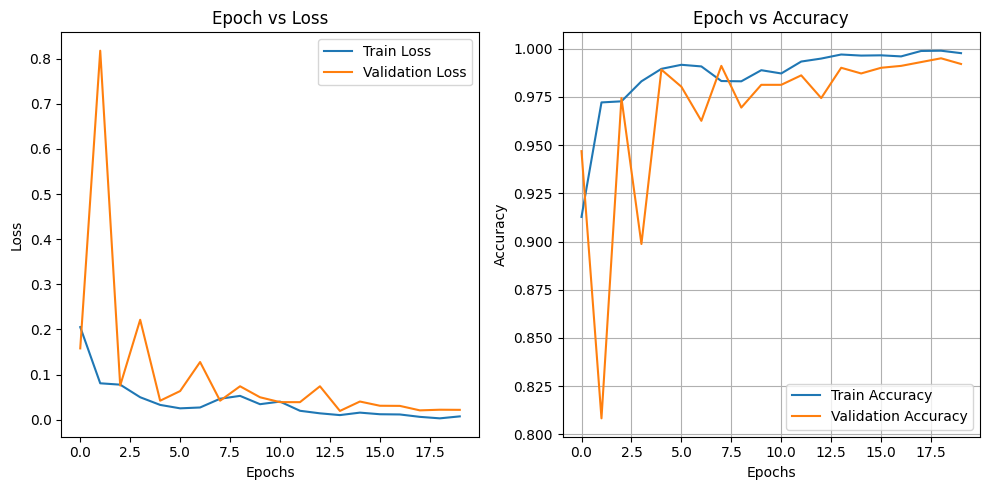

/var/tmp/ipykernel_27849/3409955228.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|████████████████████████████████████████


Test Metrics:
--------------------------------------------------
Loss      : 0.0372
Accuracy  : 0.9887
Precision : 0.9869
Recall    : 0.9830
True Negatives : 1258
False Positives: 10
False Negatives: 13
True Positives : 753
F1 Score  : 0.9850
ROC AUC   : 0.9876
Metrics for class 0:
  Precision : 0.9888
  Recall    : 0.9263
  F1 Score  : 0.9565
  ROC AUC   : 0.9623
True Negatives : 582
False Positives: 1
False Negatives: 7
True Positives : 88
--------------------
Metrics for class 1:
  Precision : 0.9868
  Recall    : 0.9933
  F1 Score  : 0.9900
  ROC AUC   : 0.9948
True Negatives : 526
False Positives: 2
False Negatives: 1
True Positives : 149
--------------------
Metrics for class 2:
  Precision : 0.9866
  Recall    : 0.9904
  F1 Score  : 0.9885
  ROC AUC   : 0.9729
True Negatives : 150
False Positives: 7
False Negatives: 5
True Positives : 516
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93 

In [40]:
if __name__ == "__main__":
    num_classes=3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize Model, Loss, and Optimizer
    model = CustomResNet(num_classes).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Run the main function
    tvt(org_train_loader, org_val_loader, org_test_loader, model, criterion, optimizer, num_epochs=20)

In [41]:
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_model(org_test_loader, "saved_model.pt", criterion)

/var/tmp/ipykernel_27849/3409955228.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)
Testing: 100%|████████████████████████████████████████


Test Metrics:
--------------------------------------------------
Loss      : 0.0372
Accuracy  : 0.9887
Precision : 0.9869
Recall    : 0.9830
True Negatives : 1258
False Positives: 10
False Negatives: 13
True Positives : 753
F1 Score  : 0.9850
ROC AUC   : 0.9876
Metrics for class 0:
  Precision : 0.9888
  Recall    : 0.9263
  F1 Score  : 0.9565
  ROC AUC   : 0.9623
True Negatives : 582
False Positives: 1
False Negatives: 7
True Positives : 88
--------------------
Metrics for class 1:
  Precision : 0.9868
  Recall    : 0.9933
  F1 Score  : 0.9900
  ROC AUC   : 0.9948
True Negatives : 526
False Positives: 2
False Negatives: 1
True Positives : 149
--------------------
Metrics for class 2:
  Precision : 0.9866
  Recall    : 0.9904
  F1 Score  : 0.9885
  ROC AUC   : 0.9729
True Negatives : 150
False Positives: 7
False Negatives: 5
True Positives : 516
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93 

In [49]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
import cv2
image_path = "./short axis frames/LPPILOTSITTING2/125.jpg"
rgb_img = cv2.imread(image_path, 1)[:, :, ::-1]
rgb_img = rgb_img[:, 30:-20]
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]).to(device)

target_layers = model.resnet.layer4
# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(1)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

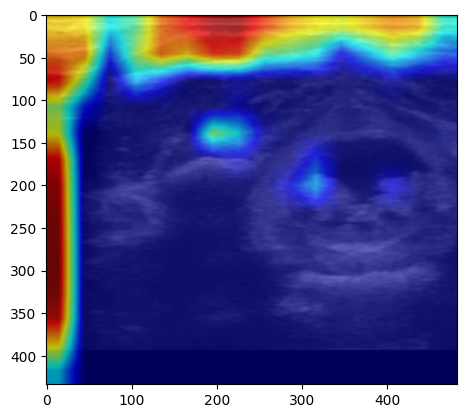

In [50]:
plt.imshow(visualization)

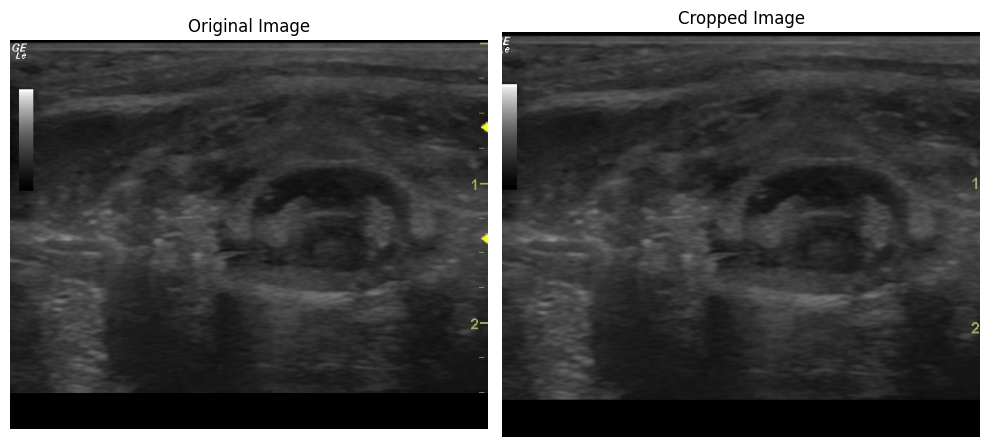

In [51]:
import cv2
import matplotlib.pyplot as plt

# Load the image from the file path
image_path = "./short axis frames/LPPILOTSITTING2/0.jpg"  # Replace with your image path
image = cv2.imread(image_path)

# Convert the image from BGR (OpenCV format) to RGB (matplotlib format)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

# Crop 10 pixels from the left and right sides
cropped_image = image[:, 10:-10]  # Keep all rows, crop columns

# Convert the cropped image to RGB
cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)

# Plot the cropped image
plt.subplot(1, 2, 2)
plt.imshow(cropped_image_rgb)
plt.title("Cropped Image")
plt.axis("off")

plt.tight_layout()
plt.show()


In [14]:
# Test Model
def test_miss_model(test_loader, model_path, criterion):
    global num_classes
    global device
    # Initialize variables to store predictions and true labels

    # Load the model
    model = load_model(model_path)

    all_preds = []
    all_labels = []

    # Test loop
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct_predictions = 0

    # Initialize the progress bar for testing
    test_progress_bar = tqdm(test_loader, total=len(test_loader), desc='Testing', position=0, leave=True)

    misclassified_images = []

    with torch.no_grad():
        image_index = 0
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicts = (outputs > 0.5).float()

            # Check for misclassifications
            for idx, (img, pred, true) in enumerate(zip(images, predicts, labels)):
                if not torch.equal(pred, true):
                    misclassified_images.append({
                        'image_index': image_index + idx,  # Store the index
                        'image': img.cpu(),  # Store the image tensor
                        'predicted_labels': pred.cpu().numpy(),
                        'true_labels': true.cpu().numpy()
                    })

            # ... [rest of your existing code in the loop] ...
            # Store predictions and true labels for later metrics calculation
            all_preds.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            acc = (predicts == labels).sum().item() / (images.size(0) * num_classes)
            loss = criterion(outputs, labels)

            test_loss = loss.item()
            test_running_loss += test_loss * images.size(0)
            test_correct_predictions += acc * images.size(0)

            # Update the progress bar with the loss and accuracy
            test_progress_bar.set_postfix({'Batch Loss': test_loss, 'Batch Accuracy': acc})

            image_index += images.size(0)

    # Calculate average loss and accuracy for the test set
    test_epoch_loss = test_running_loss / len(test_loader.dataset)
    test_epoch_accuracy = test_correct_predictions / len(test_loader.dataset)

    # Calculate other metrics
    precision = precision_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    recall = recall_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    f1 = f1_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    roc_auc = roc_auc_score(np.array(all_labels).flatten(), np.array(all_preds).flatten())
    tn, fp, fn, tp = confusion_matrix(np.array(all_labels).flatten(), np.array(all_preds).flatten()).ravel()

    print("\n" + "="*50)
    print(f'Test Metrics:')
    print(f'{"-"*50}')
    print(f'Loss      : {test_epoch_loss:.4f}')
    print(f'Accuracy  : {test_epoch_accuracy:.4f}')
    print(f'Precision : {precision:.4f}')
    print(f'Recall    : {recall:.4f}')
    print(f'True Negatives : {tn}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print(f'True Positives : {tp}')
    print(f'F1 Score  : {f1:.4f}')
    print(f'ROC AUC   : {roc_auc:.4f}')
    print("="*50)

    # Initialize variables to store class-wise metrics
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_roc_aucs = []

    # Calculate metrics for each class
    num_classes = np.array(all_labels).shape[1]  # Assuming all_labels is a 2D array
    for i in range(num_classes):
        y_true = np.array(all_labels)[:, i]
        y_pred = np.array(all_preds)[:, i]

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)
        class_roc_aucs.append(roc_auc)

        print(f"Metrics for class {i}:")
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1 Score  : {f1:.4f}")
        print(f"  ROC AUC   : {roc_auc:.4f}")
        print(f'True Negatives : {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print(f'True Positives : {tp}')
        print("-"*20)

    # If you want a summary report
    print("Summary Classification Report:")
    print(classification_report(np.array(all_labels), np.array(all_preds), zero_division=0))

    # Print or return the misclassified images
    print(f"Total Misclassified Images: {len(misclassified_images)}")
    for misclassified in misclassified_images:
        print(f"Image Index: {misclassified['image_index']}, Predicted Labels: {misclassified['predicted_labels']}, True Labels: {misclassified['true_labels']}")

    return all_labels, all_preds, misclassified_images

In [15]:
criterion = nn.BCELoss()
all_labels, all_preds, misclassified_images = test_miss_model(org_test_loader, "saved_model.pt", criterion)

Testing: 100%|██████████| 22/22 [00:04<00:00,  4.47it/s, Batch Loss=1.33e-5, Batch Accuracy=1]


Test Metrics:
--------------------------------------------------
Loss      : 0.1083
Accuracy  : 0.9813
Precision : 0.9758
Recall    : 0.9732
True Negatives : 1269
False Positives: 18
False Negatives: 20
True Positives : 727
F1 Score  : 0.9745
ROC AUC   : 0.9796
Metrics for class 0:
  Precision : 0.9439
  Recall    : 0.9439
  F1 Score  : 0.9439
  ROC AUC   : 0.9667
True Negatives : 565
False Positives: 6
False Negatives: 6
True Positives : 101
--------------------
Metrics for class 1:
  Precision : 0.9724
  Recall    : 0.9658
  F1 Score  : 0.9691
  ROC AUC   : 0.9791
True Negatives : 528
False Positives: 4
False Negatives: 5
True Positives : 141
--------------------
Metrics for class 2:
  Precision : 0.9838
  Recall    : 0.9818
  F1 Score  : 0.9828
  ROC AUC   : 0.9692
True Negatives : 176
False Positives: 8
False Negatives: 9
True Positives : 485
--------------------
Summary Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94

In [16]:
#function for all missclassified images

import matplotlib.pyplot as plt
import math

def show_misclassified_images(misclassified_images):
    num_images = len(misclassified_images)
    num_cols = 5  # You can adjust the number of columns
    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    for i in range(num_images):
        img_info = misclassified_images[i]
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']
        index = img_info['image_index']  # Get the image index

        ax = axs[i // num_cols, i % num_cols]  # Determine row and column position
        ax.imshow(img)
        ax.set_title(f"Index: {index}\nPred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for i in range(num_images, num_rows * num_cols):
        axs[i // num_cols, i % num_cols].axis('off')

    plt.show()


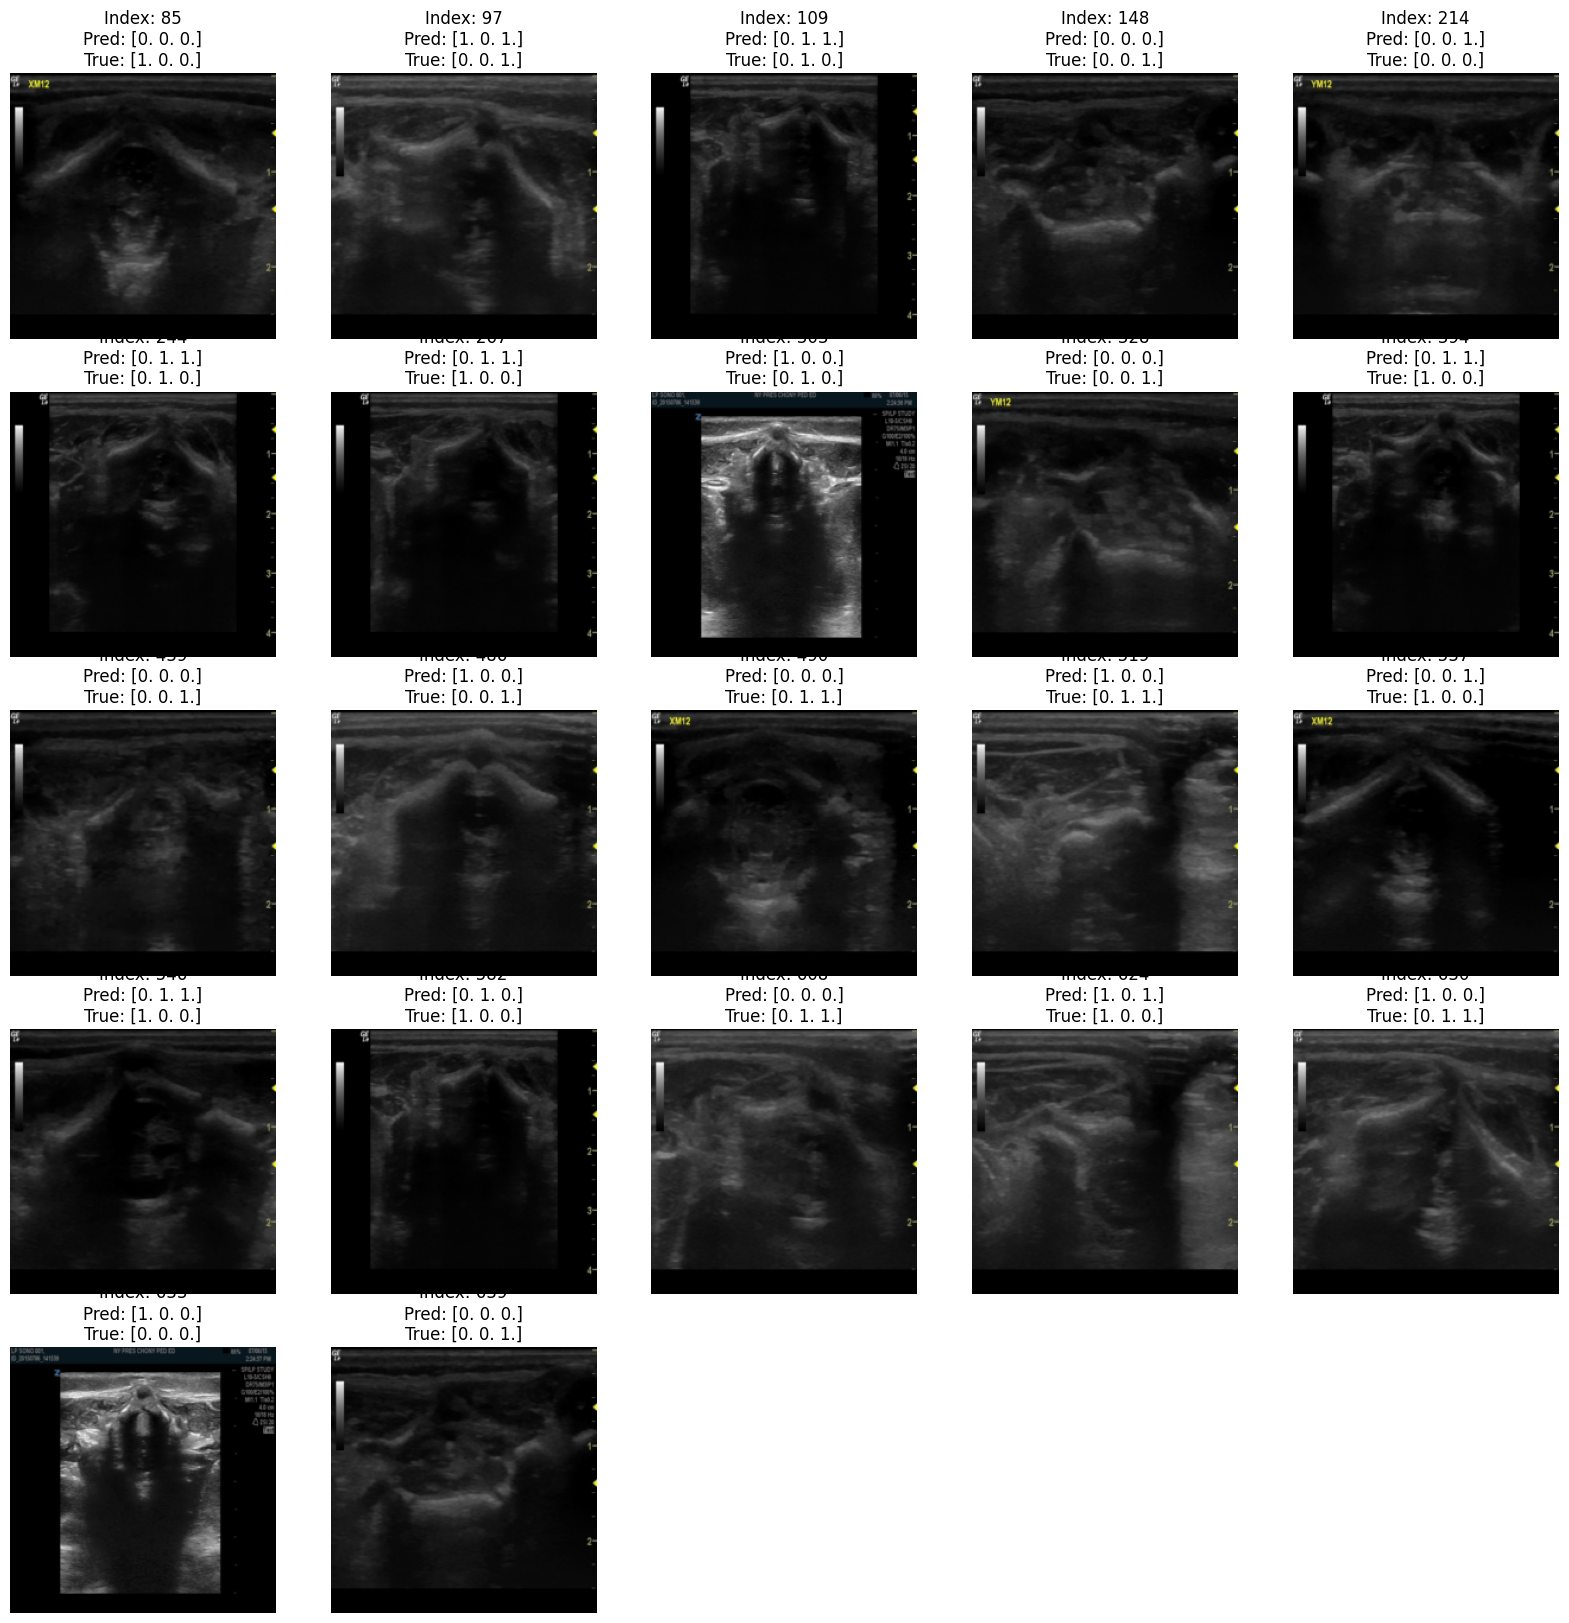

In [17]:
# Now display the misclassified images
show_misclassified_images(misclassified_images)

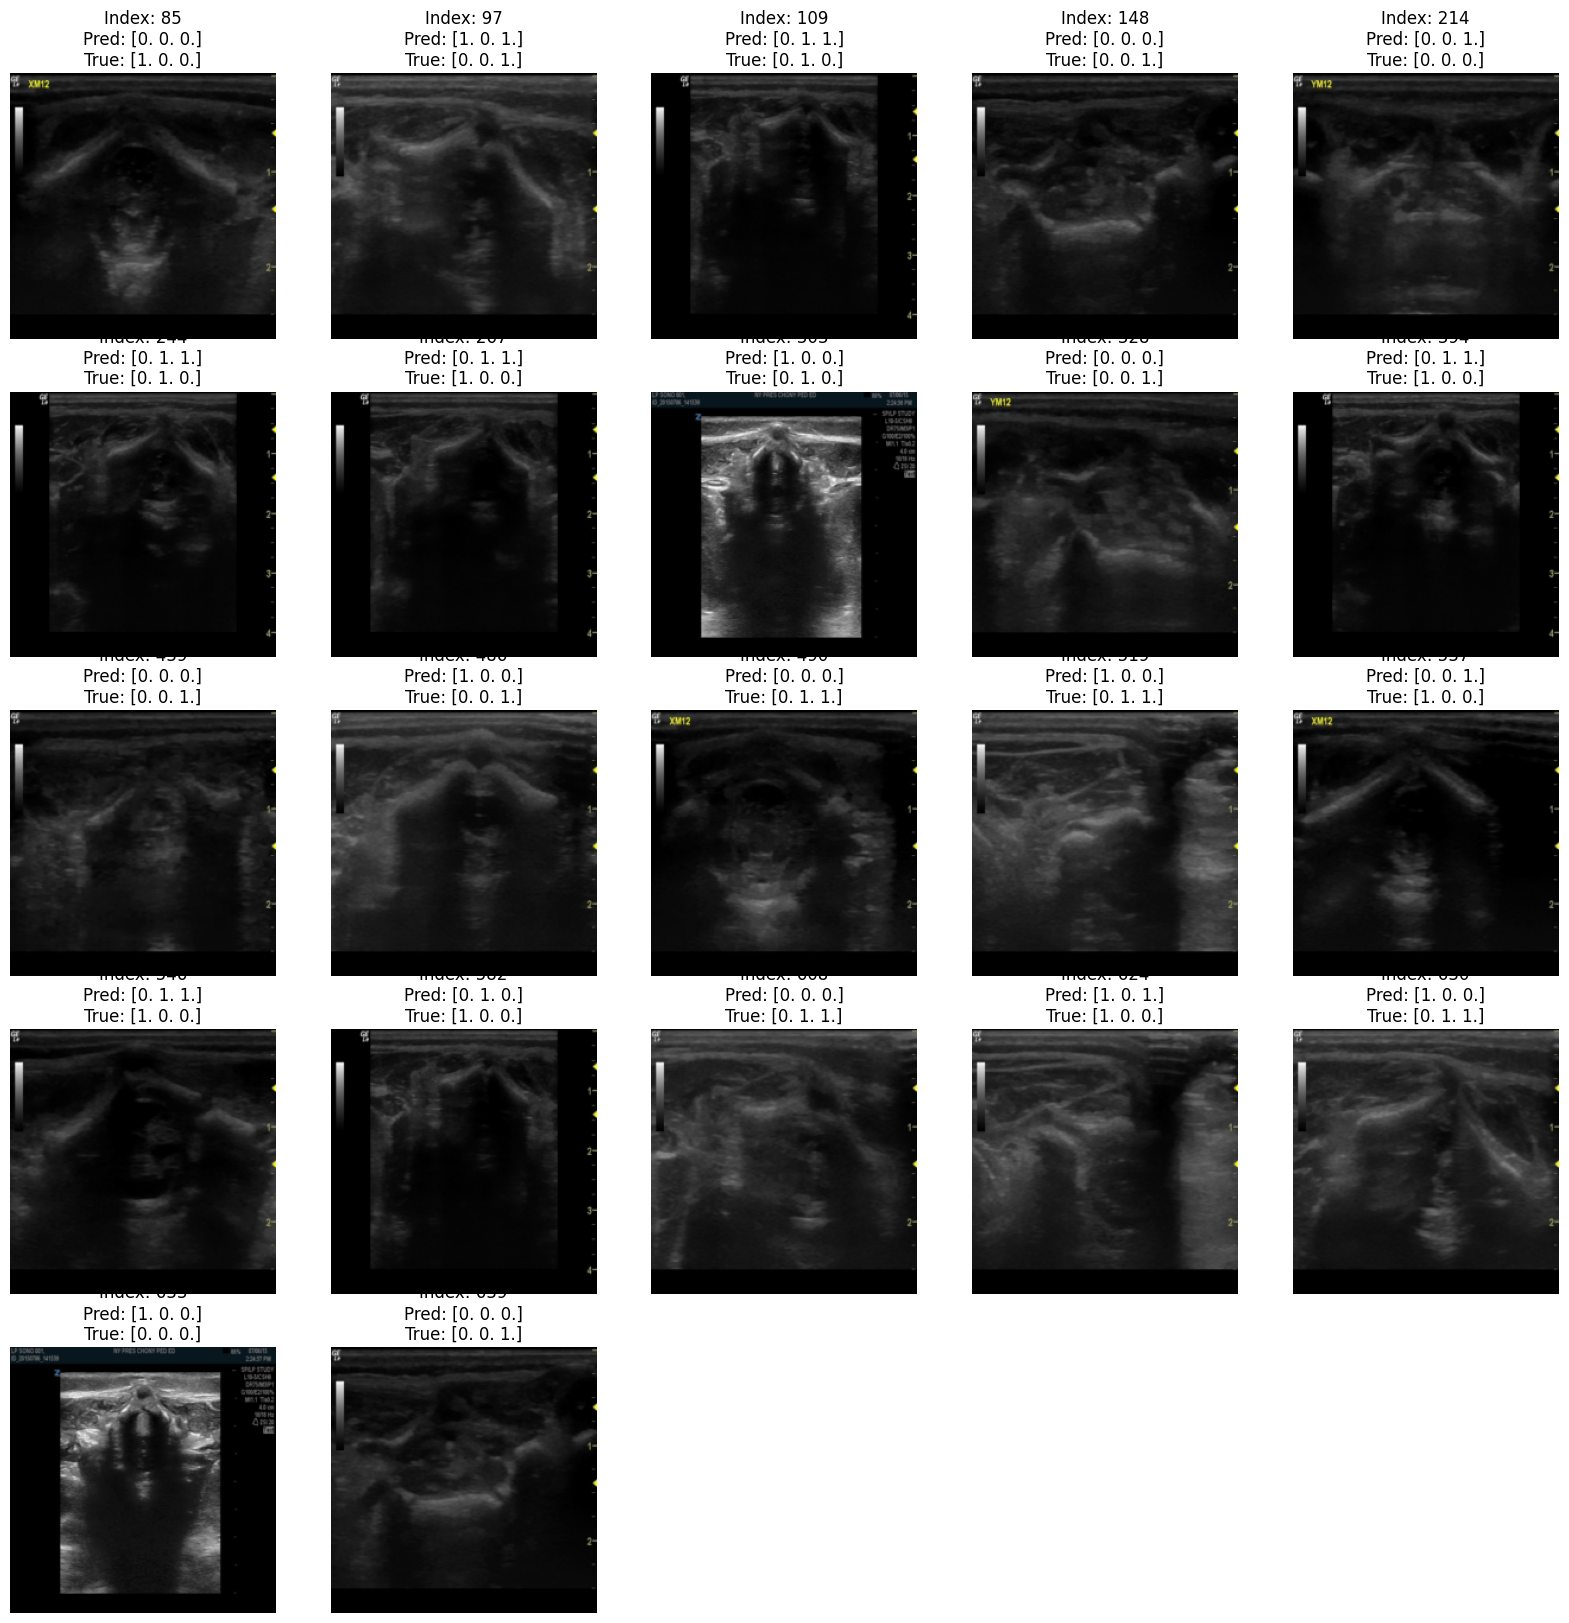

In [18]:
#calling all misclassified images

show_misclassified_images(misclassified_images)

In [19]:
def calculate_fp_fn(misclassified_images, num_classes):
    # Initialize counters
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes

    # Analyze each misclassified image
    for img_info in misclassified_images:
        predicted_labels = img_info['predicted_labels']
        true_labels = img_info['true_labels']

        for i in range(num_classes):
            # False positive: predicted is 1, true is 0
            if predicted_labels[i] == 1 and true_labels[i] == 0:
                false_positives[i] += 1
            # False negative: predicted is 0, true is 1
            elif predicted_labels[i] == 0 and true_labels[i] == 1:
                false_negatives[i] += 1

    return false_positives, false_negatives

# Call this function after you have the misclassified_images list
false_positives, false_negatives = calculate_fp_fn(misclassified_images, 3)

# Print the results
print("False Positives per Class:", false_positives)
print("False Negatives per Class:", false_negatives)


False Positives per Class: [6, 4, 8]
False Negatives per Class: [6, 5, 9]


False Positives per Class: [11, 0, 0]

For the first class (let's call it Class 1), your model incorrectly predicted the positive label (predicted as '1') 11 times when the true label was negative (actual '0'). This means there were 11 instances where the model thought the feature corresponding to Class 1 was present, but it actually wasn't.
For the second and third classes (Class 2 and Class 3), there were no false positives. This means the model never incorrectly predicted the presence of these features; it did not mistakenly identify these features in any of the images where they were actually absent.
False Negatives per Class: [0, 3, 10]

For Class 1, there were no false negatives. This means that whenever the feature corresponding to Class 1 was present in an image, the model always identified it correctly.
For Class 2, there were 3 instances where the model failed to identify the presence of the feature (predicted as '0') when it was actually present (true '1'). In other words, the model missed this feature 3 times when it should have detected it.
For Class 3, the situation is more pronounced with 10 false negatives. This indicates that the model frequently failed to recognize the presence of the feature corresponding to Class 3.

In [39]:
def filter_specific_misclassifications(misclassified_images):
    filtered_images = []
    for img_info in misclassified_images:
        true_labels = img_info['true_labels']
        predicted_labels = img_info['predicted_labels']
        # Check if Class 1 is '1' and Class 2 & 3 are '0' in true labels
        # and if Class 1 is correctly predicted as '1'
        if true_labels[0] == 1 and true_labels[1] == 0 and true_labels[2] == 0 and predicted_labels[0] == 1:
            filtered_images.append(img_info)
    return filtered_images

specific_misclassifications = filter_specific_misclassifications(misclassified_images)

def show_filtered_images(filtered_images, num_cols=5):
    num_images = len(filtered_images)
    if num_images == 0:
        print("No images meet the specified criteria.")
        return

    num_rows = math.ceil(num_images / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))

    for i, img_info in enumerate(filtered_images):
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']

        # Handle the case when axs is 1-dimensional
        if num_images <= num_cols:
            ax = axs[i]  # Index as a 1D array
        else:
            ax = axs[i // num_cols, i % num_cols]  # Index as a 2D array

        ax.imshow(img)
        ax.set_title(f"Pred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        if num_images <= num_cols:
            axs[j].axis('off')  # Index as a 1D array
        else:
            axs[j // num_cols, j % num_cols].axis('off')  # Index as a 2D array

    plt.show()

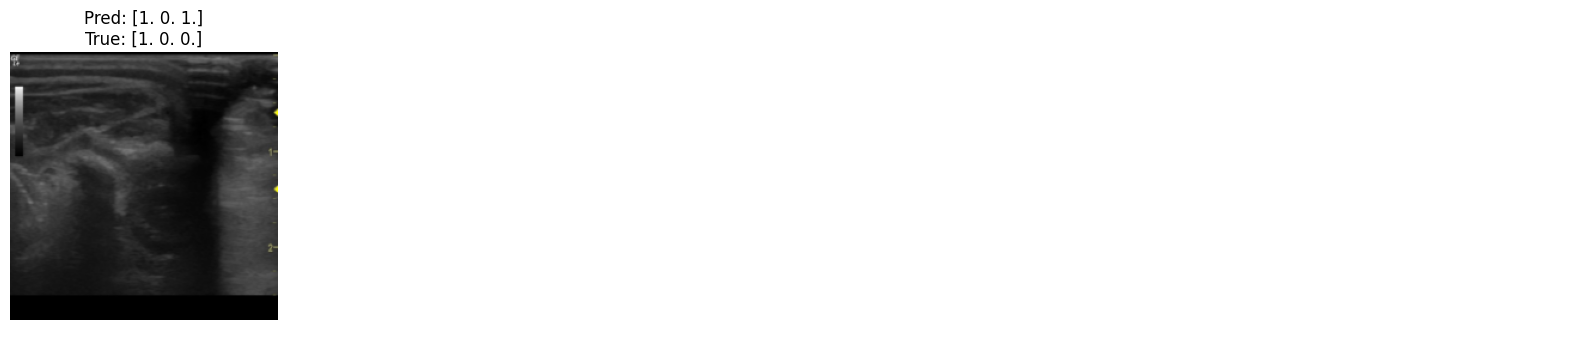

In [40]:
# Filter and show the specific misclassifications
show_filtered_images(specific_misclassifications)

In [27]:
def filter_specific_predictions(misclassified_images):
    filtered_images = []
    for img_info in misclassified_images:
        predicted_labels = img_info['predicted_labels']
        # Check if predicted Class 1 is '1' and Classes 2 & 3 are '0'
        if predicted_labels[0] == 1 and predicted_labels[1] == 0 and predicted_labels[2] == 0:
            filtered_images.append(img_info)
    return filtered_images

specific_predictions = filter_specific_predictions(misclassified_images)

import matplotlib.pyplot as plt
import math

def show_filtered_images(filtered_images, num_cols=5):
    num_images = len(filtered_images)
    if num_images == 0:
        print("No images meet the specified criteria.")
        return

    num_rows = math.ceil(num_images / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    # If there's only one row, axs will be 1D, so we need to handle this case
    if num_rows == 1:
        axs = [axs]  # Make axs a list of lists

    for i, img_info in enumerate(filtered_images):
        img = img_info['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        predicted = img_info['predicted_labels']
        true = img_info['true_labels']
        ax = axs[i // num_cols][i % num_cols] # Access the correct element now that axs is 2D
        ax.imshow(img)
        ax.set_title(f"Pred: {predicted}\nTrue: {true}")
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, num_rows * num_cols):
        axs[j // num_cols][j % num_cols].axis('off')  # Access correctly

    plt.show()

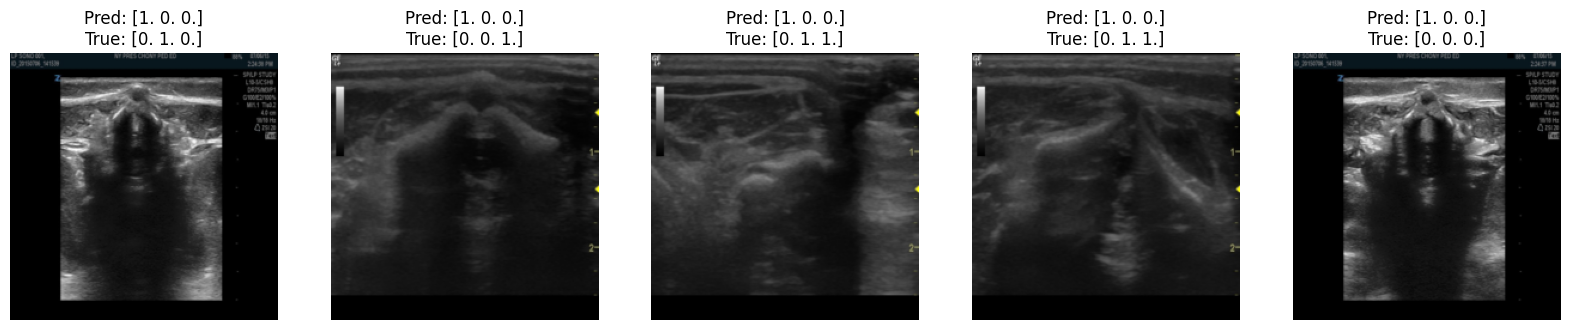

In [28]:
# Filter and show the specific predictions
show_filtered_images(specific_predictions)